# Description of File

The importance of this file will be to demonstrate the basics of the Pemberton 2015 paper on a small domain, ie the Barents Sea Opening. Specifically, we will look first at the mass budget in TS space, then try to decompose the TS plots into a series of terms for the mass budget in T and S separately.

# Packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
annual = False     # decide if doing time-averaging or not
m = 1

# Grid

In [3]:
iB = 6
tsnap = 2

path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)


# Create mskBasin and gateways

In [5]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
# mymsk[mymsk != iB] = np.nan

In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

LwetC2d 146614
LwetC 4833023



# Read the files

We want theta, salt, volume, mass terms

In [42]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2004"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
# times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [43]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [44]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.full((len(tsstr),nz, ny, nx),np.nan)
ETANS = np.full((len(tsstr),ny,nx),np.nan)
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) #* mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol

print(vol.shape)

volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)


In [45]:
# surface FW flux
# rewrite with only reading in these lines, be sure to compare
oceFWflx = np.full((int(len(tsstr)),ny,nx),np.nan)
SIatmFW = np.full((int(len(tsstr)),nz,ny,nx),np.nan)

meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
    oceFWflxi,its,meta = rdmds(dirIn + "budg2d_zflux_set1", read,returnmeta=True,rec = recs[0])
    # Net freshwater flux from atmosphere & land (+=down)
    SIatmFWi,its,meta = rdmds(dirIn + "budg2d_zflux_set1", read,returnmeta=True,rec = recs[1])

    # set them in the bigger array
    oceFWflx[t] = oceFWflxi.reshape(ny,nx)
    SIatmFW[t] = SIatmFWi.reshape(ny,nx)

In [46]:
TFLUX = np.full((int(len(tsstr)),ny,nx),np.nan)
SFLUX = np.full((int(len(tsstr)),ny,nx),np.nan)

file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]
    
    # Vertical Mass-Weighted Comp of Velocity
    TFLUXi,its,meta = rdmds(dirIn + file_name, read,returnmeta=True,rec = recs[0])
    SFLUXi,its,meta = rdmds(dirIn + file_name, read,returnmeta=True,rec = recs[1])

    TFLUX[i] = TFLUXi.reshape(ny,nx)
    SFLUX[i] = SFLUXi.reshape(ny,nx)

# Create freshwater content and heat map in Atlantic Water layer

In [47]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

(400.0, 780.0)

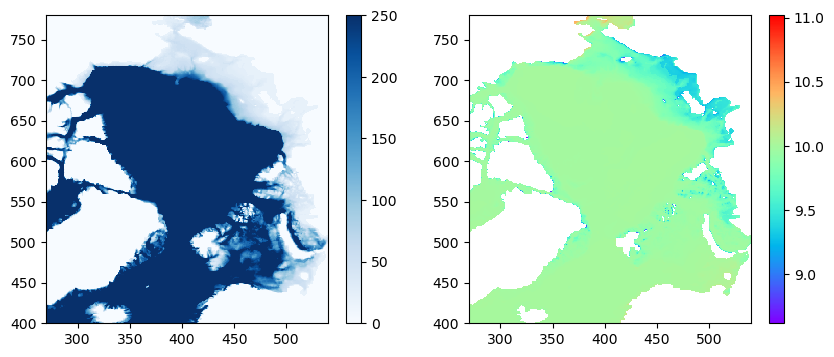

In [48]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(DD,nfx,nfy)[0],cmap="Blues",vmax=250)
plt.colorbar(cb)
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(vol[0],nfx,nfy)[0],cmap="rainbow")
plt.colorbar(cb)
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)

In [49]:
# this is to look at depths we want to select for the file
# np.cumsum(mygrid['DRF'])[16:29]

In [50]:
# set up for time averaging
sref = 34.8  #41.05      # PSU
filter = drf3d.copy() * mygrid['hFacC']
filter[filter >= 254] = np.nan
filter[filter < 254] = 1
FWcontent = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)): 
    # for calculating freshwater content:
        # FW volume * (1- salinity/reference salinity)    m^3
        # integrate over surface to 254 m based on the np.where(np.cumsum(mygrid['DRF'])<254)
        # look at the time average of this
    
    # do step 1 to get FW volume and only look at the values at less than 254 m
    saltnorm = 1-(salt[i]/sref)
    FWvol = vol[i] * mygrid['hFacC'] * (1-salt[i]/sref)
    FWvol = FWvol[:19]
    
    # vertically integrate
    FWcontent[i] = np.nansum(FWvol,axis=0)

In [51]:
FWcontent.shape
annual = True

In [52]:
# do time averaging of FW content
if annual:
    FWcontent = np.mean(FWcontent,axis=0)
else:
    FWcontent = FWcontent[m]

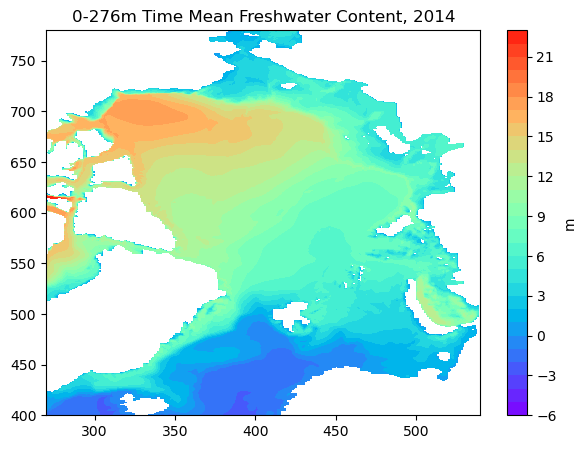

In [53]:
# this is just a snap, but we can plot it anyways to see
data = get_aste_tracer(FWcontent, nfx, nfy)[0]

# Create the contour plot
fig = plt.figure(figsize=(7,5))
# plt.contourf(data, cmap="rainbow", vmax=5e9, vmin=-5e9,levels=np.arange(-5e9,5e9,5e8))
plt.contourf(data, cmap="rainbow", vmax=24, vmin=-6,levels=np.arange(-6,24,1))
plt.colorbar(label="m")
plt.pcolormesh(landmsk,cmap="Greys")
plt.xlim(270, 540)
plt.ylim(400, 780)
plt.title("0-276m Time Mean Freshwater Content, 2014")
plt.show()

In [54]:
np.cumsum(mygrid['DRF'])[14:29] #[16:29]

array([ 162.49,  182.31,  207.16,  238.26,  276.68,  323.18,  378.18,
        441.68,  513.26,  592.16,  677.31,  767.49,  861.45,  958.03,
       1056.28])

In [55]:
# Now look at the potential temperature maximum in the AW layer
    # select from the temperature where there is depth beween 200-1000m
    # find the maximum T value in the axis 0
    # do time averaging of these

Tmax = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    # do step 1 to get FW volume and only look at the values at less than 254 m
    tempsel = theta[i,14:29,:,:]
    tempsel = np.nanmax(tempsel,axis=0)

    Tmax[i] = tempsel

/tmp/ipykernel_1061620/333902102.py:11: RuntimeWarning: All-NaN slice encountered
  tempsel = np.nanmax(tempsel,axis=0)


In [56]:
if annual:
    Tmax = np.nanmean(Tmax,axis=0)
else:
    Tmax = Tmax[m]

/tmp/ipykernel_1061620/1825782547.py:2: RuntimeWarning: Mean of empty slice
  Tmax = np.nanmean(Tmax,axis=0)


In [57]:
# data = get_aste_tracer(Tmax, nfx, nfy)[0]

# # Define the boundaries for the segments
# boundaries = [-3, 0, 3, 6]

# # Create the colormaps for each segment
# cmap1 = plt.cm.Blues(np.linspace(0, 1, 128))
# cmap2 = plt.cm.seismic(np.linspace(0, 1, 128))
# cmap3 = plt.cm.rainbow(np.linspace(0, 1, 128))

# # Combine the colors into a single array
# colors = np.vstack((cmap1, cmap2, cmap3))

# # Create a custom colormap from the combined colors
# custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=384)

# # Define the levels for contouring
# levels = np.linspace(-3, 6, 200)

# # Create a BoundaryNorm to map data values to the segments
# norm = mcolors.BoundaryNorm(boundaries, ncolors=len(levels) - 1)

# # Generate the plot
# fig, ax = plt.subplots()
# cb = ax.contourf(data, levels=levels, cmap=custom_cmap)
# fig.colorbar(cb, boundaries=boundaries, ticks=boundaries)

# plt.xlim(270, 540)
# plt.ylim(400, 780)
# plt.pcolormesh(landmsk, cmap="Greys")

# plt.show()

In [58]:
# data = get_aste_tracer(Tmax,nfx,nfy)[0]

# ArcWater = data.copy()
# ArcWater[ArcWater >=0 ] = np.nan

# AtlWater = data.copy()
# AtlWater[AtlWater <=2.7] = np.nan

# Intermed = data.copy()
# Intermed[Intermed <0] = np.nan
# Intermed[Intermed >=3.1] = np.nan

In [59]:
# # another way we could do this is by masking and doing 3 separate calls to plot

# fig,ax = plt.subplots(figsize=(7,5))
# cb1 = ax.contourf(ArcWater,vmin=-2,vmax=0,cmap="cool",levels = np.arange(-2,0.25,.25))
# plt.colorbar(cb1)
# cb2 = ax.contourf(Intermed,vmin=0,vmax=3,cmap="bwr",levels = np.arange(0,3.3,.1))
# plt.colorbar(cb2)
# cb3 = ax.contourf(AtlWater,vmin=3,vmax=8,cmap="Reds_r",levels = np.arange(2.7,8,.25))
# plt.colorbar(cb3)

# # plt.colorbar(label="Potential T")
# # plt.pcolormesh(landmsk,cmap="Greys")
# plt.xlim(270, 540)
# plt.ylim(400, 780)
# # plt.title("162-1056m Time Mean Tmax, 2014")

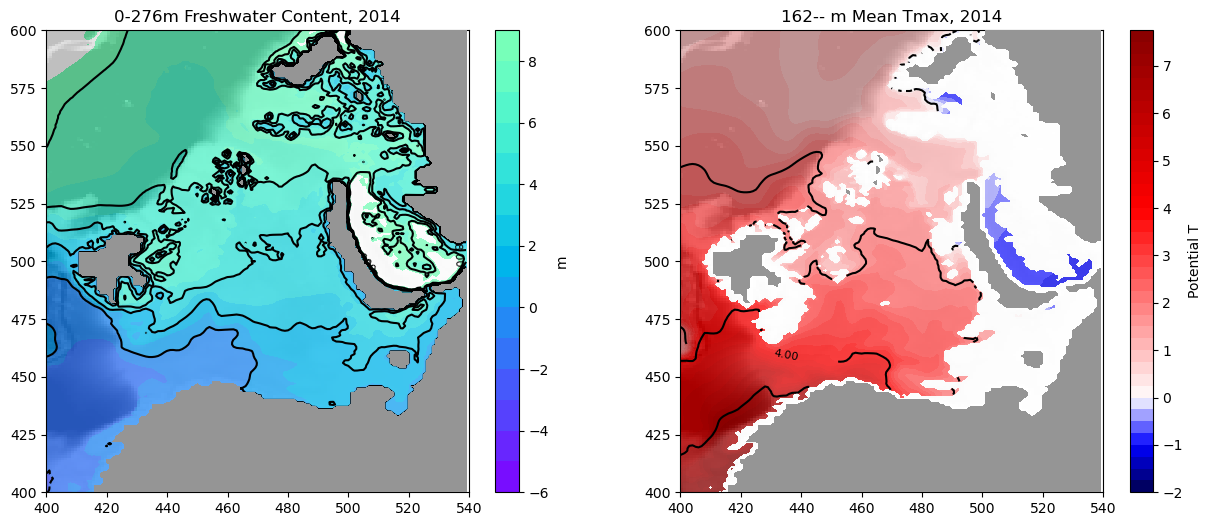

In [60]:
# do side by side subplots

fig = plt.figure(figsize = (15,6))

# salinity subplot
ax = plt.subplot(121)
data = get_aste_tracer(FWcontent, nfx, nfy)[0]
# plt.contourf(data, cmap="rainbow", vmax=24, vmin=-6,levels=np.arange(-6,24,1))
# contours = ax.contour(data,levels = np.arange(-6,24,4),colors="black")
plt.contourf(data, cmap="rainbow", vmax=24, vmin=-6,levels=np.arange(-6,10,1))
contours = ax.contour(data,levels = np.arange(-6,10,2),colors="black")
ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
plt.colorbar(label="m")
ax.set_xlim(400, 540)
ax.set_ylim(400, 600)
# ax.set_title("0-276m Time Mean Freshwater Content, 2014")
ax.set_title("0-276m Freshwater Content, 2014")
ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,1))
ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",alpha=0.25,vmax=3000)

# temperature subplot
ax = plt.subplot(122)
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=8)
# cb = plt.contourf(get_aste_tracer(Tmax,nfx,nfy)[0],cmap="seismic",levels=np.arange(-2,8,.25),norm=norm)
# contours = ax.contour(get_aste_tracer(Tmax,nfx,nfy)[0],levels = np.arange(-2,8,2),colors="black")
cb = plt.contourf(get_aste_tracer(Tmax,nfx,nfy)[0],cmap="seismic",levels=np.arange(-2,8,.25),norm=norm)
contours = ax.contour(get_aste_tracer(Tmax,nfx,nfy)[0],levels = np.arange(-2,8,2),colors="black")
ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
ax.set_xlim(400, 540)
ax.set_ylim(400, 600)
y = np.array([535,715])
x = np.array([455,310])
# plt.plot(x,y,zorder=10,linestyle="dashed",color="black")
# ax.set_title("162-1056m Mean Tmax, 03/2014")
ax.set_title("162-- m Mean Tmax, 2014")
plt.colorbar(cb,label="Potential T")
ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,1))
ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",alpha=0.25,vmax=3000)

# plt.savefig(path + "pemberton_fig3_2014_v3.png",dpi=300)
# plt.savefig(path + "Barents_FW_Tmax_2014.png",dpi=300)

# do a section with the Tmax and the cross section of temperature at the BSO and at the gate to Arctic

In [61]:
gg.keys()

dict_keys(['FramStrait', 'NaresStrait', 'CAA', 'BarrowStrait/LancasterSound', 'BarentsSeaOpening', 'Svalbard-FranzJosefIslands', 'FranzJosefIslands-NovayaZemlya', 'KaraStrait', 'StAnnaTrough/Voronin/Vilkitshogo', 'BeringStrait', 'DenmarkStrait', 'Iceland-FaroeI', 'Faroe-Shetland', 'GibraltarStrait', 'DavisStrait', 'FloridaStrait', 'BeringSea', 'SubPolarGyre', 'LabradorSea'])

In [62]:
# do time averaging
theta_avg = np.nanmean(theta,axis=0)
salt_avg = np.nanmean(salt,axis=0)

/tmp/ipykernel_1061620/1217946335.py:2: RuntimeWarning: Mean of empty slice
  theta_avg = np.nanmean(theta,axis=0)
/tmp/ipykernel_1061620/1217946335.py:3: RuntimeWarning: Mean of empty slice
  salt_avg = np.nanmean(salt,axis=0)


(400.0, 450.0)

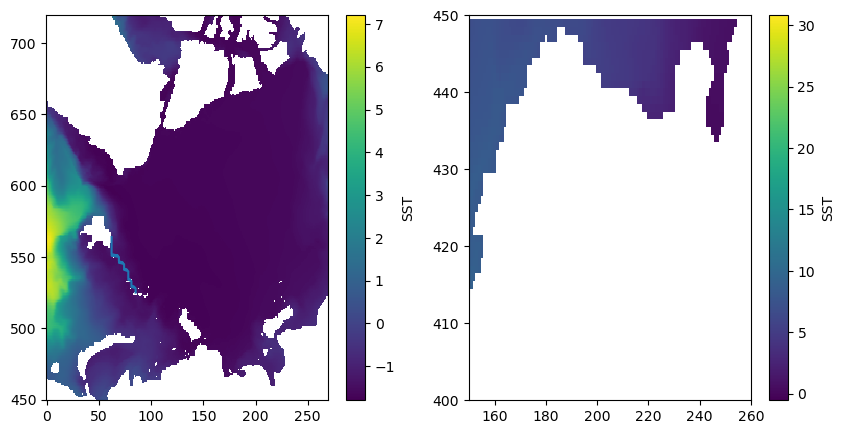

In [63]:
# show an example gate

fig = plt.figure(figsize=(10,5))

# face 3
ax = plt.subplot(121)
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))
cb = ax.pcolormesh(XV,YV,theta_avg[0][450:720,:270])
ax.plot(gg["Svalbard-FranzJosefIslands"]["ix"],gg["Svalbard-FranzJosefIslands"]["jy"])
plt.colorbar(cb,label="SST")

# face 1 - scatter the points with the selected TS values
ax = plt.subplot(122)
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(0,450,1))
cb = ax.pcolormesh(XV,YV,theta_avg[0][0:450,:270])
ax.plot(gg["Svalbard-FranzJosefIslands"]["ix"][:21],gg["Svalbard-FranzJosefIslands"]["jy"][:21])
plt.colorbar(cb, label="SST")
ax.set_xlim(150,260)
ax.set_ylim(400,450)

In [64]:
# y = np.array([])

# num_points = max(abs(y[1] - y[0]), abs(x[1] - x[0])) + 1
# num_points

In [65]:
# select the gate for x and y
y = gg["Svalbard-FranzJosefIslands"]["jy"]
x = gg["Svalbard-FranzJosefIslands"]["ix"]

# I think we're selecting from the cross section wrong here - we should not be doing this
dx = mygrid['DXG'][y,x]
dy = mygrid['DYG'][y,x]
distances = np.sqrt(dx**2 + dy**2)
cumulative_distance = np.cumsum(distances)
cumulative_distance /=1000 # km

# get the cross section S and T data from the averages of theta and salt
cross_sectionT = theta_avg[:,y,x]
cross_sectionS = salt_avg[:,y,x]
z_indices = np.arange(cross_sectionT.shape[0])

In [66]:
ivalid = np.where(~np.isnan(cross_sectionT[0]))

In [67]:
# XVc[:,ivalid][:,0,:].shape
cross_sectionT[:,ivalid].shape

(50, 1, 56)

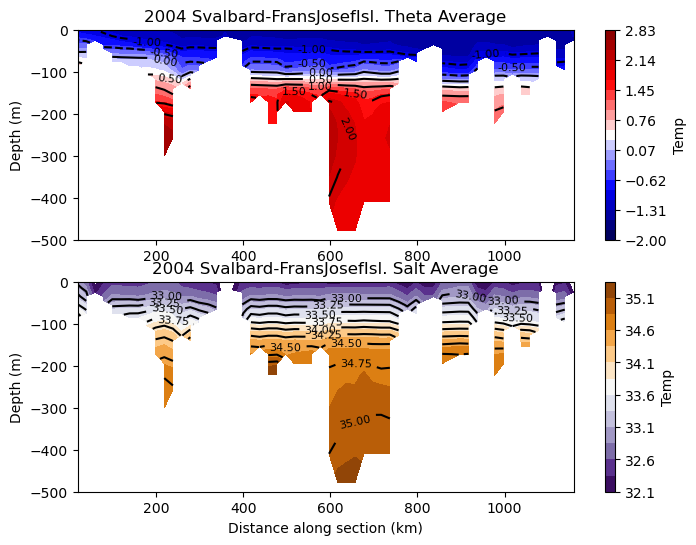

In [68]:
# do just for the BSO opening so we can look in TS space

# Extract the cross-section along the interpolated line
XVc,YVc = np.meshgrid(cumulative_distance[::-1],mygrid['RC'])


fig = plt.figure(figsize=(8,6))

ax = plt.subplot(211)

# Plot a contourf of the potential temperature
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4.5)
cb = plt.contourf(XVc[:,ivalid][:,0,:],YVc[:,ivalid][:,0,:], cross_sectionT[:,ivalid][:,0,:],cmap="seismic",levels=np.arange(-2,3,.23))  # Visualize the first layer of the 3D array
plt.colorbar(cb, extend="both",label="Temp")
plt.ylim(-1500,0)

# Add contour lines for theta
theta_levels = np.arange(-2,3,.5)
contours = plt.contour(XVc[:,ivalid][:,0,:],YVc[:,ivalid][:,0,:], cross_sectionT[:,ivalid][:,0,:], colors='black',levels=theta_levels)
plt.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
plt.ylim(-500,0)

# add labels
# ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("2004 Svalbard-FransJosefIsl. Theta Average")


# add another subplot for the temperature
ax = plt.subplot(212)
norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4.5)
cb = plt.contourf(XVc[:,ivalid][:,0,:],YVc[:,ivalid][:,0,:], cross_sectionS[:,ivalid][:,0,:],cmap="PuOr_r",levels=np.arange(32.1,35.4,.25))  # Visualize the first layer of the 3D array
plt.colorbar(cb, extend="both",label="Temp")
plt.ylim(-1500,0)

# Add contour lines for theta
theta_levels = np.arange(33,36,.25)
contours = plt.contour(XVc[:,ivalid][:,0,:],YVc[:,ivalid][:,0,:], cross_sectionS[:,ivalid][:,0,:], colors='black',levels=theta_levels)
plt.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
plt.ylim(-500,0)

# add labels
ax.set_xlabel("Distance along section (km)")
ax.set_ylabel("Depth (m)")
ax.set_title("2004 Svalbard-FransJosefIsl. Salt Average")


plt.savefig(path + "Svb_FJI_2004_TS_gate.png",dpi=300)

In [69]:
# # plot this aside the other figure for Tmax


# fig = plt.figure(figsize = (13,11))

# # Tmax subplot
# ax = plt.subplot(221)
# norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=8)
# cb = plt.contourf(get_aste_tracer(Tmax,nfx,nfy)[0],cmap="seismic",levels=np.arange(-2,8,.25),norm=norm)
# contours = ax.contour(get_aste_tracer(Tmax,nfx,nfy)[0],levels = np.arange(-2,8,1),colors="black")
# ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
# ax.set_xlim(400, 540)
# ax.set_ylim(400, 600)
# y = np.array([535,715])
# x = np.array([455,310])
# ax.set_title("162-- m Mean Tmax, 2004")
# plt.colorbar(cb,label="Potential T")
# ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,.2))
# ax.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",alpha=0.25,vmax=3000)

# # plt.savefig(path + "pemberton_fig3_2014_v3.png",dpi=300)
# plt.savefig(path + "Barents_FW_Tmax_2004.png",dpi=300)

# Time-mean freshwater and heat flux into the Arctic

In [154]:
# freshwater flux first - we're looking at oceFWflx (kg m^2/s) and SIatmFW (kg m^2/s)
oceFWflxavg = np.nanmean(oceFWflx,axis=0)
SIatmFWavg  = np.nanmean(SIatmFW,axis=0)
surfFWflx = oceFWflxavg+SIatmFWavg

In [155]:
# surface heat flux - TFLUX (W/m^2)
TFLUXavg = np.nanmean(TFLUX,axis=0)

In [156]:
# surface salt flux - SFLUX
SFLUXavg = np.nanmean(SFLUX,axis=0)

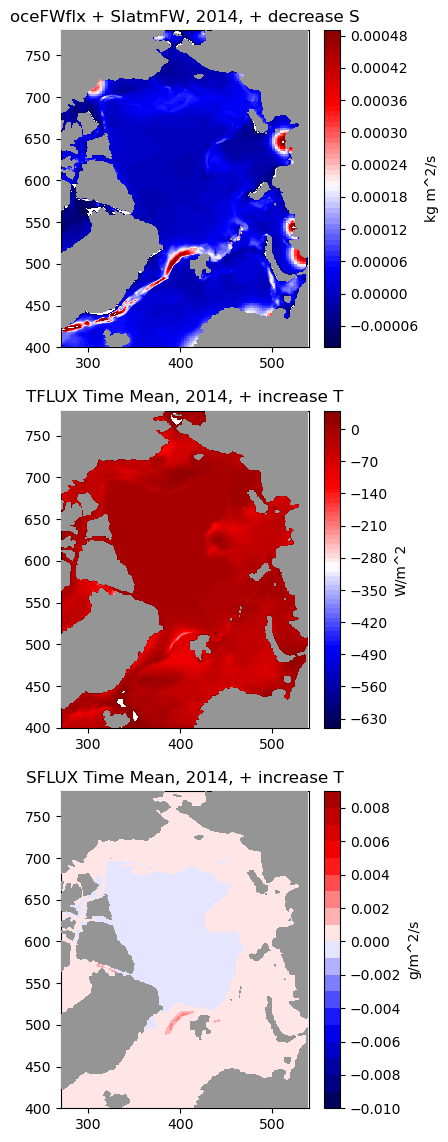

In [157]:
# do side by side subplots
fig = plt.figure(figsize = (4,14))

# FW subplot
ax = plt.subplot(311)
data = get_aste_tracer(surfFWflx, nfx, nfy)[0]
cb = ax.contourf(data, cmap="seismic", vmax=.0005, vmin=-.0001,levels=np.arange(-1e-4,5e-4,.00001),zorder=1)
plt.colorbar(cb,label="kg m^2/s")
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)
ax.set_title("oceFWflx + SIatmFW, 2014, + decrease S")
ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,1))

# TFLUX subplot
ax = plt.subplot(312)
cb = plt.contourf(get_aste_tracer(TFLUXavg,nfx,nfy)[0],cmap="seismic",vmin=-650,vmax=50,levels=np.arange(-650,50,10))
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)
ax.set_title("TFLUX Time Mean, 2014, + increase T")
plt.colorbar(cb,label="W/m^2")
ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,1))

# SFLUX subplot
ax = plt.subplot(313)
cb = plt.contourf(get_aste_tracer(SFLUXavg,nfx,nfy)[0],cmap="seismic",vmin=-.01,vmax=.01,levels=np.arange(-.01,.01,.001))
ax.set_xlim(270, 540)
ax.set_ylim(400, 780)
ax.set_title("SFLUX Time Mean, 2014, + increase T")
plt.colorbar(cb,label="g/m^2/s")
ax.contourf(landmsk,cmap="Greys",zorder=5,levels=np.arange(-1,3,1))

plt.savefig(path + "pemberton_fig5_2014.png",dpi=300)